## Indoor Locationing Predictions using WiFi Fingerprinting
### Author: Mauricio Amoni

**Background**
Our client is developing a system to help people navigate a complex, unfamiliar interior space on a college campus.
They would like us to investigate the feasibility of using WiFi fingerprinting to determine a person's indoor location.
If a model meets or exceeds minimum specifications, it will be incorporated into a smart phone app for indoor locationing on a college campus.
Client Minimum Specifications
Indoor location must be as precise as predicting within 10-15 feet of the indoor room, also defined as ‘SpaceID’ within source data. Relative position, or whether individual is outside or inside of room, is unnecessary.

**Ideal performance metrics to achieve:**

1.- Accuracy scores on test data reaches 80% or higher

2.- Precision (accuracy of minority class) on test data reaches 80% or higher

3.- Recall (coverage of minority class) on test data is 80% or higher

4.- F1 Score for multi-class problem achieves 80% or higher

In [52]:
# import libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
from pprint import pprint

# helpers
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# estimators
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# model metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [53]:
df = pd.read_csv('/Users/mauricio/Downloads/UJIndoorLoc/trainingData.csv')

In [54]:
df.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


## Evaluate Data

In [55]:
# check structure
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Data columns (total 529 columns):
 #    Column            Non-Null Count  Dtype  
---   ------            --------------  -----  
 0    WAP001            19937 non-null  int64  
 1    WAP002            19937 non-null  int64  
 2    WAP003            19937 non-null  int64  
 3    WAP004            19937 non-null  int64  
 4    WAP005            19937 non-null  int64  
 5    WAP006            19937 non-null  int64  
 6    WAP007            19937 non-null  int64  
 7    WAP008            19937 non-null  int64  
 8    WAP009            19937 non-null  int64  
 9    WAP010            19937 non-null  int64  
 10   WAP011            19937 non-null  int64  
 11   WAP012            19937 non-null  int64  
 12   WAP013            19937 non-null  int64  
 13   WAP014            19937 non-null  int64  
 14   WAP015            19937 non-null  int64  
 15   WAP016            19937 non-null  int64  
 16   WAP017            19

### Observations
Columns 0:520 have same structure, all are integers representing WiFi Access Points (WAP).
A new dataframe subsetting out 1 WAP and last 9 columns will be helpful
Notice no nulls

In [56]:
selected_columns = df.iloc[:,519:529]
selected_columns.head()

,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [57]:
# check structure
selected_columns.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WAP520            19937 non-null  int64  
 1   LONGITUDE         19937 non-null  float64
 2   LATITUDE          19937 non-null  float64
 3   FLOOR             19937 non-null  int64  
 4   BUILDINGID        19937 non-null  int64  
 5   SPACEID           19937 non-null  int64  
 6   RELATIVEPOSITION  19937 non-null  int64  
 7   USERID            19937 non-null  int64  
 8   PHONEID           19937 non-null  int64  
 9   TIMESTAMP         19937 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.5 MB


In [58]:
# summary statistics
selected_columns.describe()

,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.0,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.0,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.0,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.0,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


In [59]:
# check unique values for variables indicating a location

In [60]:
df['FLOOR'].unique()

array([2, 0, 3, 4, 1])

In [61]:
df['BUILDINGID'].nunique()

3

In [62]:
df['SPACEID'].nunique()

123

In [63]:
df['RELATIVEPOSITION'].nunique()

2

<AxesSubplot:>

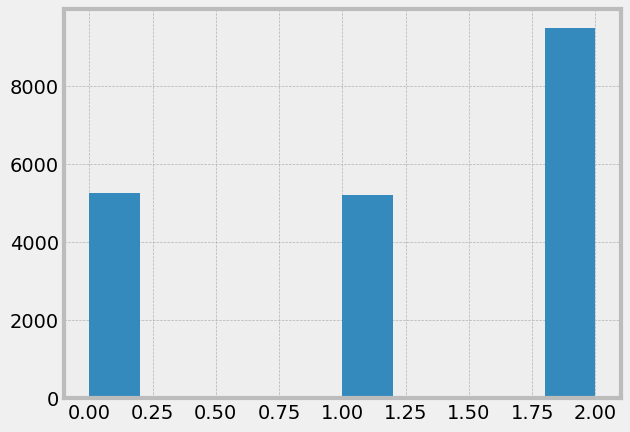

In [64]:
plt.style.use('bmh')
df['BUILDINGID'].hist()

<AxesSubplot:>

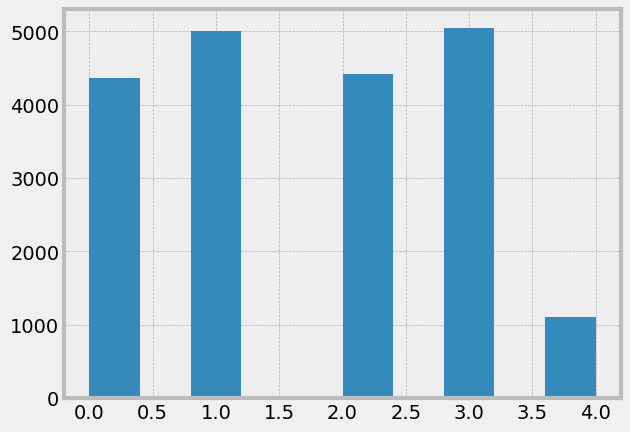

In [179]:
plt.style.use('bmh')
df['FLOOR'].hist()

(array([ 242.,  155.,  117.,  116.,  106.,   59.,   42.,   66.,   19.,
           0.,   10.,   19.,   39.,   37.,   22.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  418.,  833.,  805.,  944., 1010.,  636.,
         523.,  440.,  522.,  521.,  593.,  426.,  561.,  557.,  539.,
         384.,  445.,  414.,  326.,  508.,   96.,  160.,   40.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  902.,  604.,
         498.,  431.,  371.,  328.,  389.,  411.,  542.,  241.,  294.,
         322.,  226.,  217.,  239.,   99.,  220.,  160.,   99.,   75.,
          79.,  110.,  140.,  140.,   20.,   30.]),
 array([  1.        ,   3

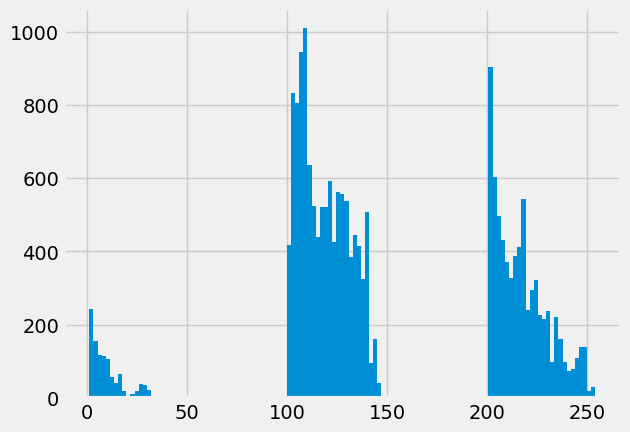

In [66]:
# histogram of SPACEID
plt.hist(df['SPACEID'], bins=123)

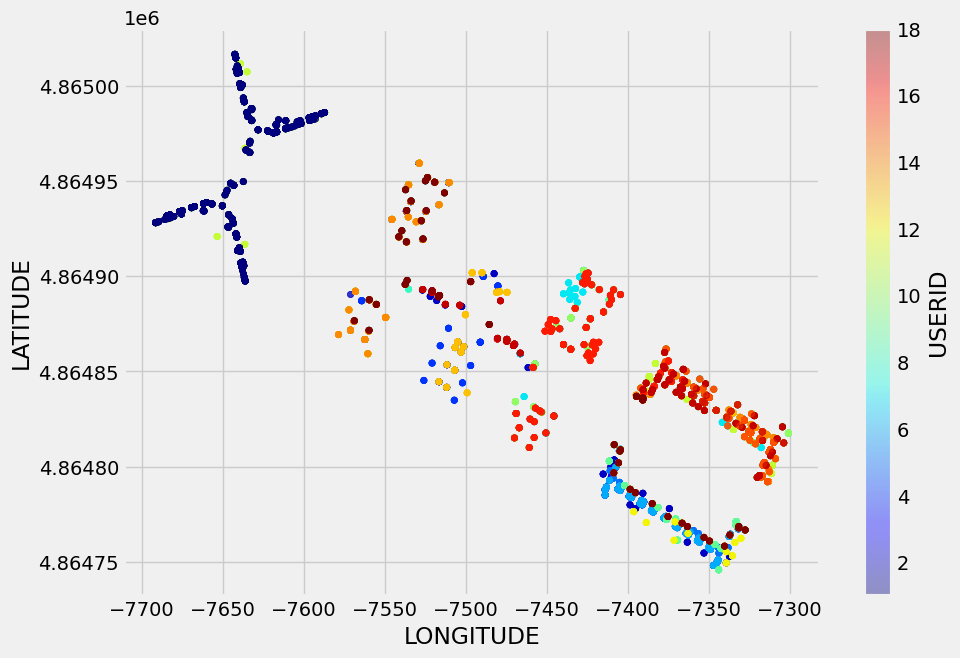

In [161]:
#map data by User ID

df.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", alpha=0.4, figsize=(10,7),
    c="USERID", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.savefig('user_map2.png')

Text(0.5, 1.0, 'Correlation')

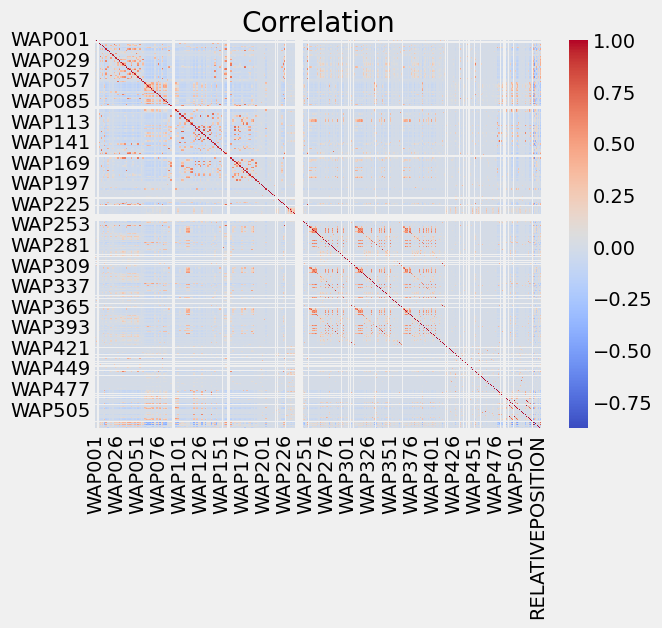

In [159]:
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Correlation')

**Comment:** While checking the correlation between WAP inputs, we can see small pockets of correlation between the data. However, most of the data is not highly correlated and will not affect our classification accuracy. Nevertheless, to avoid the curse of dimentionality, I will reduce the number of features.

In [160]:
#pip install openpyxl

### Feature Engineering 

In [68]:
# create unique id for predicting specific campus location, as the dependent variable
df['location']=df['BUILDINGID'].astype(str)+''+df['FLOOR'].astype(str)+''+df['SPACEID'].astype(str)

In [69]:
df.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,location
0,100,100,100,100,100,100,100,100,100,100,...,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733,12106
1,100,100,100,100,100,100,100,100,100,100,...,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691,12106
2,100,100,100,100,100,100,100,-97,100,100,...,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095,12103
3,100,100,100,100,100,100,100,100,100,100,...,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807,12102
4,100,100,100,100,100,100,100,100,100,100,...,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710,00122


In [70]:
df.location.nunique()

735

Text(0.5, 1.0, 'Signal Distribution')

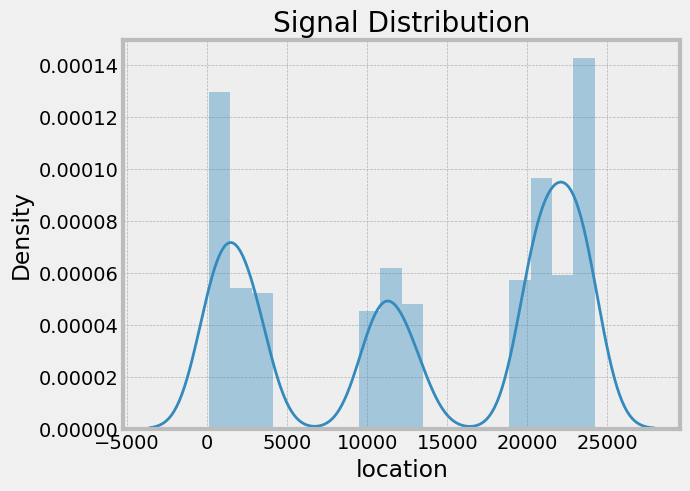

In [185]:
sns.distplot(df['location'])
plt.title("Signal Distribution")

In [ ]:
sns.stripplot(x="LONGITUDE", y="LATITUDE", data=df,jitter=True,hue='location',palette='Set1')

### Comments:
There are **735** different classes, or room locations, to predict. The Wifi Access Points will serve as the independent variables during algorithm training.

In [71]:
# move dependent variable 'location' to front for easy x and y identification
df = df[ ['location'] + [ col for col in df.columns if col != 'location'] ]

In [72]:
df.head()

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,12106,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,12106,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,12103,100,100,100,100,100,100,100,-97,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,12102,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,00122,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


## Feature selection and sampling
#### Dataset 1: out-of-box (df1)

In [73]:
# drop any non-WAP variable (can only use WiFi Access Points as features)
df1 = df.drop(df.columns.to_series()['LONGITUDE':'TIMESTAMP'], axis=1)
df1['location'].nunique()

735

In [74]:
df1['location'].dtypes

dtype('O')

In [75]:
df1.head()

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
2,12103,100,100,100,100,100,100,100,-97,100,...,100,100,100,100,100,100,100,100,100,100
3,12102,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,00122,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


Text(0.5, 1.0, 'Correlation')

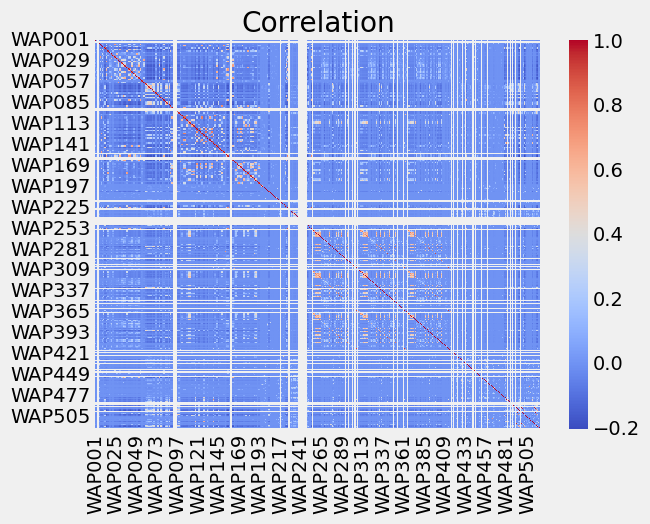

In [163]:
sns.heatmap(df1.corr(), cmap='coolwarm')
plt.title('Correlation')

In [76]:
X = df1.iloc[:,1:]
y = df1['location']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [81]:
# prepare models
algos_Class = []
algos_Class.append(('Decision Tree', DecisionTreeClassifier(criterion='entropy')))
algos_Class.append(('Random Forest', RandomForestClassifier()))
algos_Class.append(('Support Vector Machines', SVC(kernel='rbf')))
algos_Class.append(('K Nearest Neighbors', KNeighborsClassifier()))

In [82]:
# filter warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [83]:
# evaluate each model in turn on df1
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

In [84]:
# cross validation results
for i in range(len(names)):
    print(names[i], results[i].mean(), results[i].std())

Decision Tree 0.4563891630646426 0.06864650796187423
Random Forest 0.6749279425360831 0.07613702886691302
Support Vector Machines 0.512967279076801 0.07101144891264868
K Nearest Neighbors 0.4743465616247085 0.07399875971935883


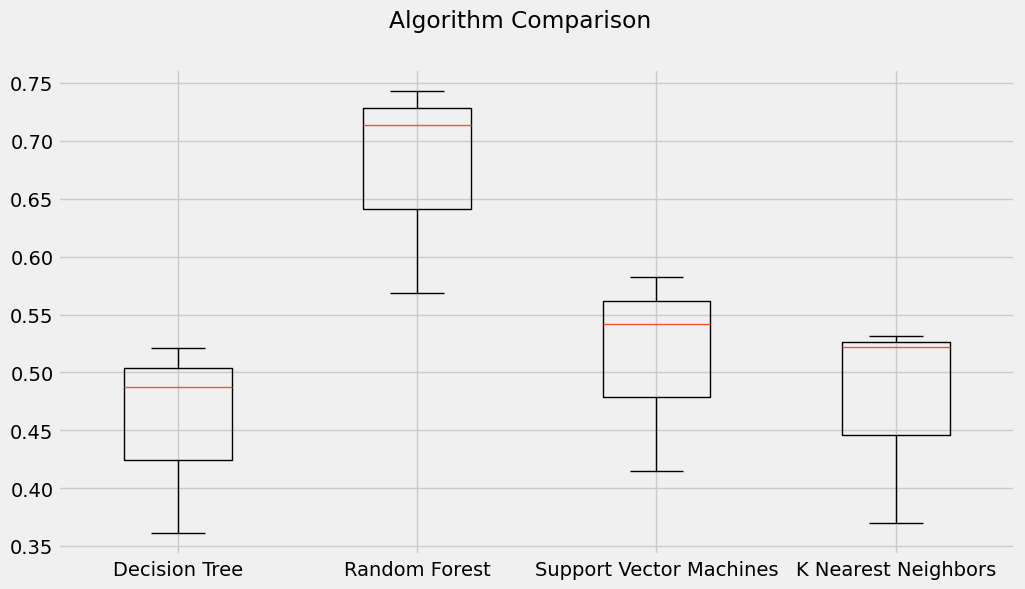

In [175]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Random Forest and Support Vector Machines are top two algorithms worthy of further study

In [87]:
# tune random forest
rf = RandomForestClassifier()

# parameters currently in use
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [94]:
# model tuning
rf = RandomForestClassifier(criterion='entropy', 
                            n_estimators=200,
                            n_jobs=-1,
                            random_state=123)
rf_df1 = rf.fit(X_train, y_train)

# predictions
y_preds = rf_df1.predict(X_test)
# assessment
print('Accuracy Score: '), accuracy_score(y_test, y_preds)

Accuracy Score: 


(None, 0.8079237713139418)

In [89]:
# Random Forest df1 metrics compiled
print(('Accuracy: '), accuracy_score(y_test, y_preds))
print(('Precision: '), precision_score(y_test, y_preds, average='weighted'))
print(('Recall: '), recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)))
print(('F1: '), f1_score(y_test, y_preds, average='weighted'))

Accuracy:  0.8079237713139418
Precision:  0.852607130021112
Recall:  0.8110421211612686
F1:  0.8092273282041701


**Notes:**

Although accuracy is a useful metric, for this problem, recall is also important. Recall gauges how many spaces our model correctly classifies (True Positives) out of all Actual Positives within each class. There is a high cost associated with a False Negative (incorrect room prediction) when being considered for deploying in a Smart Phone app. To get another sense of how well our model did, we will sum the number of spaces that fall within Recall quartiles and compare at the very end.

In [95]:
# Dataframe comparing predictions to y_test 'ground truth'
y_test = pd.DataFrame(y_test)
y_test.head()

# predictions dataframe
y_preds = pd.DataFrame(y_preds)
# rename prediction column
y_preds = y_preds.rename(columns={0: 'RFpreds_df1'})

# comparison dataframe
rf_compare_df1 = pd.concat([y_test, y_preds.set_index(y_test.index)], axis=1)
rf_compare_df1.head(10)

,location,RFpreds_df1
6195,12202,12202
13675,23121,23121
16554,03225,03225
222,12101,12101
1550,125,125
5386,13201,13201
15355,10248,10248
10625,11109,11109
12827,103,101
17404,00230,00230


Notes:
Although accuracy is a useful metric, for this problem, recall is also important. Recall gauges how many spaces our model correctly classifies (True Positives) out of all Actual Positives within each class. There is a high cost associated with a False Negative (incorrect room prediction) when being considered for deploying in a Smart Phone app. To get another sense of how well our model did, we will sum the number of spaces that fall within Recall quartiles and compare at the very end.

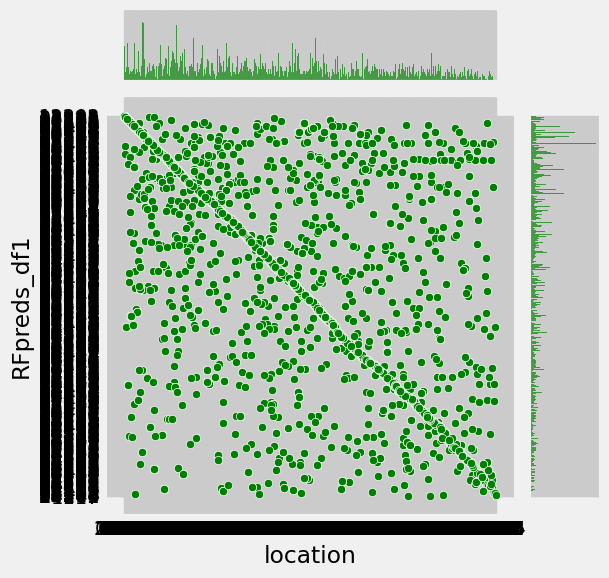

In [100]:
sns.jointplot(x='location', y='RFpreds_df1', data=rf_compare_df1,color='green')

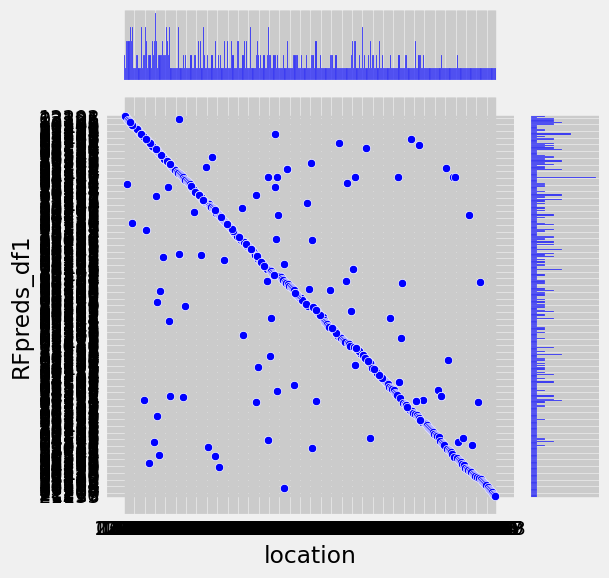

In [118]:
sns.jointplot(x='location', y='RFpreds_df1', data=rf_compare_df1.head(500),color='blue')

In [124]:
rf_compare_df1['location'].dtype

dtype('O')

In [148]:
dt =str(rf_compare_df1['location'])


<AxesSubplot:xlabel='location', ylabel='Density'>

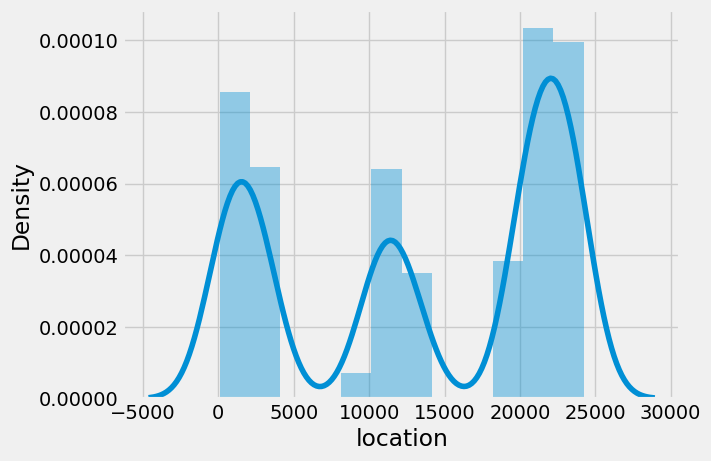

In [167]:
df1.head()

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
2,12103,100,100,100,100,100,100,100,-97,100,...,100,100,100,100,100,100,100,100,100,100
3,12102,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,00122,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [178]:
sns.violinplot(x="location", y="df1.iloc[:,1:]", data=df1,palette='rainbow')

ValueError: Could not interpret input 'df1.iloc[:,1:]'